# Importing libaries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from data_cleaning import data_cleaner

# Data Cleaning

In [2]:
data_cleaner('data/cardio_data.csv', 'data/cardio_data_clean.csv')

In [3]:
cardio_data = pd.read_csv('data/cardio_data_clean.csv')
cardio_data.head()

,age,gender,blood_pressure_max,blood_pressure_min,cholesterol_level,glucose_level,smoking_status,alcohol_status,activity_level,disease,blood_pressure_diff,bmi
0,58,1,140,90,2,1,0,0,1,1,50,25.909457
1,61,0,180,90,1,1,0,0,1,1,90,39.758205
2,55,0,140,90,2,2,0,0,1,1,50,31.248764
3,54,0,130,80,1,3,0,0,1,1,50,29.000595
4,41,1,110,60,1,1,0,0,1,1,50,24.577867


# EDA

In [ ]:
# EDA.ipynb notebook

# Data Preprocessing

In [40]:
from sklearn.model_selection import train_test_split

X = cardio_data.drop(columns = ['disease'])
y = cardio_data['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [0]:
X_train = pd.read_csv('cardio_train_predictors.csv').drop(columns = ['Unnamed: 0'])
X_test = pd.read_csv('cardio_test_predictors.csv').drop(columns = ['Unnamed: 0'])
y_train = pd.read_csv('cardio_train_target.csv', header = None)[1]
y_test = pd.read_csv('cardio_test_target.csv', header = None)[1]

In [0]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df, numerical_columns):
    numerical_df = df[numerical_columns]
    categorical_df = df.drop(columns = numerical_columns)

    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns = numerical_df.columns, index = numerical_df.index)

    processed_df = pd.merge(scaled_df, categorical_df, left_index = True, right_index = True)
    return processed_df

In [0]:
numerical_columns = ['age', 'bmi', 'blood_pressure_max', 'blood_pressure_min', 'blood_pressure_diff', 'cholesterol_level', 'glucose_level']

X_train_processed = data_preprocessor(X_train, numerical_columns)
X_test_processed = data_preprocessor(X_test, numerical_columns)

# Modelling

## Logistic regression

### Training model

In [0]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
base_lr_model = lr.fit(X_train_processed, y_train)

y_test_hat = base_lr_model.predict(X_test_processed)

### Calculating performance metrics

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

def classification_metrics(y, y_hat):
    accuracy = round(accuracy_score(y, y_hat), 3)
    auc_score = round(roc_auc_score(y, y_hat), 3)
    precision = round(precision_score(y, y_hat), 3)
    recall = round(recall_score(y, y_hat), 3)
    f1_score = round(2 * (precision * recall) / (precision + recall), 3)
    print("(accuracy = {}, auc_score = {})".format(accuracy, auc_score))
    print("")
    print("(precision = {}, recall = {}, f1-score = {})".format(precision, recall, f1_score))
    return None

In [53]:
classification_metrics(y_test, y_test_hat)

(accuracy = 0.731, auc_score = 0.731)

(precision = 0.758, recall = 0.681, f1-score = 0.717)


### Plotting ROC curve

In [0]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fprs, tprs, model_name):
    plt.plot([0,1], [0,1], 'k--', label = "Random")
    plt.plot(fprs, tprs, label = model_name)
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc = "lower right")
    return plt.show();

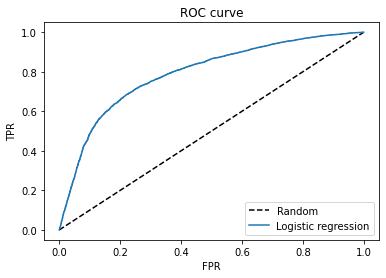

In [54]:
log_odds = base_lr_model.decision_function(X_test_processed)
fprs, tprs, log_odds_thresholds = roc_curve(y_test, log_odds)
plot_roc_curve(fprs, tprs, "Logistic regression")

### Choosing a probability threshold

In [0]:
def log_odds_to_threshold(log_odds):
    threshold = 1/(1 + np.exp(-1 * log_odds))
    return threshold

def optimal_threshold(fprs, tprs, thresholds, log_odds = False):
    distances = []
    for fpr, tpr in zip(fprs,tprs):
        distance = np.sqrt(fpr**2 + (1-tpr)**2)
        distances.append(distance)
    sorted_distances = sorted(enumerate(distances), key = lambda x: x[1])
    best_index = sorted_distances[0][0]
    if log_odds:
      best_threshold = log_odds_to_threshold(thresholds[best_index])
    else:
      best_threshold = thresholds[best_index]
    return print("The best probability threshold is: {}".format(round(best_threshold, 2)))

In [55]:
optimal_threshold(fprs, tprs, log_odds_thresholds, True)

The best probability threshold is: 0.47


### Plotting precision/recall curve with threshold

In [0]:
def precision_recall_curve(model, X, y, thresholds):
    precisions = []
    recalls = []
    for threshold in thresholds:
        y_proba = model.predict_proba(X)[:,1]
        y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > threshold else 0))
        precision, recall = round(precision_score(y, y_pred), 3), round(recall_score(y, y_pred), 3)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls, thresholds

def plot_precision_recall_curve(precisions, recalls, thresholds, best_threshold):
    plt.plot(thresholds, precisions, label = 'Precision')
    plt.plot(thresholds, recalls, label = 'Recall')
    plt.axvline(x = 0.5, ls = ':', color = 'red')
    plt.axvline(x = best_threshold, ls = ':', color = 'green')
    if best_threshold < 0.5:
      plt.text(0.52, 0.2, 'old threshold', color = 'red')
      plt.text(best_threshold - 0.25, 0.2, 'new threshold', color = 'green')
    else:
      plt.text(0.25, 0.2, 'old threshold', color = 'red')
      plt.text(best_threshold + 0.02, 0.2, 'new threshold', color = 'green')
    plt.title('Precision Recall trade-off')
    plt.xlabel('Threshold')
    plt.ylim(0,1)
    plt.legend()
    return plt.show();

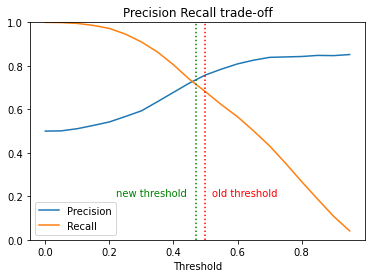

In [64]:
precisions, recalls, thresholds = precision_recall_curve(base_lr_model, X_test_processed, y_test, list(np.arange(0,1, 0.05)))
plot_precision_recall_curve(precisions, recalls, thresholds, 0.47)

### Calculating performance metrics for best threshold

In [58]:
y_proba = base_lr_model.predict_proba(X_test_processed)[:,1]
y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > 0.47 else 0))
classification_metrics(y_test, y_pred)

(accuracy = 0.731, auc_score = 0.731)

(precision = 0.739, recall = 0.715, f1-score = 0.727)


### Plotting confusion matrix for best threshold

In [0]:
def custom_confusion_matrix(y, y_hat):
    confusion_matrix = pd.crosstab(pd.Series(y), pd.Series(y_hat), rownames=['Actual'], colnames=['Predicted'])
    return sns.heatmap(confusion_matrix, annot=True, cmap = ['red', 'green'], cbar = False, fmt = 'g');

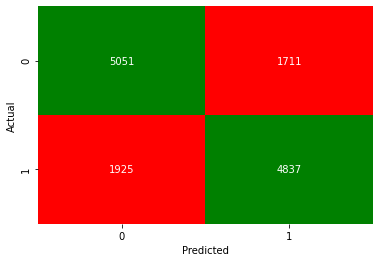

In [59]:
custom_confusion_matrix(y_test, y_pred);

## K-nearest neighbours

### Training baseline model

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

base_knn_model = knn.fit(X_train_processed, y_train)
y_test_hat = base_knn_model.predict(X_test_processed)

In [66]:
classification_metrics(y_test, y_test_hat)

(accuracy = 0.693, auc_score = 0.693)

(precision = 0.697, recall = 0.682, f1-score = 0.689)


### Hyperparameter tuning

#### Tuning k

In [0]:
from sklearn.model_selection import cross_val_score

ks = range(5,105,5)
scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = np.mean(cross_val_score(knn, X_train_processed, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

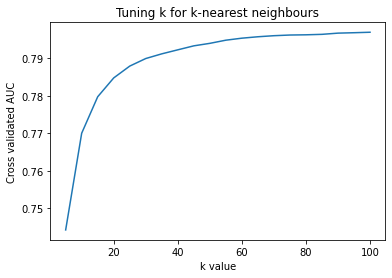

In [0]:
plt.plot(ks, scores)
plt.title('Tuning k for k-nearest neighbours')
plt.xlabel('k value')
plt.ylabel('Cross validated AUC');

#### Tuning weights and distance metric

In [0]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [50], 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'euclidean', 'cosine']}
knn_gs = GridSearchCV(knn, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time knn_gs.fit(X_train_processed, y_train)
knn_gs.best_params_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 1.72 s, sys: 67.1 ms, total: 1.79 s
Wall time: 1min 54s


{'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'uniform'}

### Training tuned model

In [0]:
tuned_knn = KNeighborsClassifier(n_neighbors = 50)

tuned_knn_model = tuned_knn.fit(X_train_processed, y_train)
y_test_hat = tuned_knn_model.predict(X_test_processed)

### Choosing a probability threshold

In [0]:
optimal_threshold(fprs, tprs, thresholds)

The best probability threshold is: 0.52


### Calculating performance metrics

In [0]:
y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > 0.52 else 0))
classification_metrics(y_test, y_pred)

(accuracy = 0.732, auc_score = 0.732)

(precision = 0.767, recall = 0.665, f1-score = 0.712)


### Plotting confusion matrix

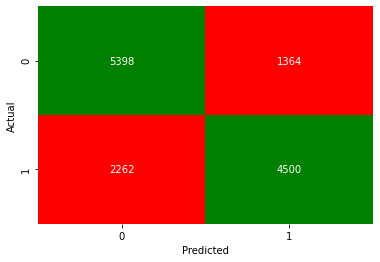

In [0]:
custom_confusion_matrix(y_test, y_pred);

## Naive Bayes Classifier

### Categorical NB

#### Preprocessing data

In [0]:
def naive_bayes_preprocessor(X):
  X_bayes = X.copy()

  min_age, max_age = X_bayes['age'].min(), X_bayes['age'].max()
  X_bayes['age_category'] = pd.cut(X_bayes['age'], bins = [min_age-1,40,45,50,55,60,max_age+1], labels = range(1,7))
  
  min_bmi, max_bmi = X_bayes['bmi'].min(), X_bayes['bmi'].max()
  X_bayes['bmi_zone'] = pd.cut(X_bayes['bmi'], bins = [min_bmi-1,17.5,25,30,max_bmi+1], labels = range(1,5))
  
  min_diastolic_bp, max_diastolic_bp = X_bayes['blood_pressure_min'].min(), X_bayes['blood_pressure_min'].max()
  X_bayes['diastolic_zone'] = pd.cut(X_bayes['blood_pressure_min'], bins = [min_diastolic_bp-1,80,90,120,max_diastolic_bp+1], labels = range(1,5))
  
  min_systolic_bp, max_systolic_bp = X_bayes['blood_pressure_max'].min(), X_bayes['blood_pressure_max'].max()
  X_bayes['systolic_zone'] = pd.cut(X_bayes['blood_pressure_max'], bins = [min_systolic_bp-1,120,140,180,max_systolic_bp+1], labels = range(1,5))

  X_bayes['blood_pressure_diff_zone'] = pd.cut(X_bayes['blood_pressure_diff'], bins = 3, labels = range(1,4))
  
  X_bayes.drop(columns = ['age', 'bmi', 'blood_pressure_min', 'blood_pressure_max', 'blood_pressure_diff'], inplace = True)
  X_bayes = X_bayes.astype('category')
  return X_bayes

In [0]:
X_train_bayes = naive_bayes_preprocessor(X_train)
X_test_bayes = naive_bayes_preprocessor(X_test)

#### Training model

In [0]:
from sklearn.naive_bayes import CategoricalNB

nb = CategoricalNB()

base_nb_model = nb.fit(X_train_bayes, y_train)
y_test_hat = base_nb_model.predict(X_test_bayes)

#### Choosing probability threshold

In [76]:
optimal_threshold(fprs, tprs, thresholds)

The best probability threshold is: 0.49


#### Calculating performance metrics

In [78]:
y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > 0.49 else 0))
classification_metrics(y_test, y_pred)

(accuracy = 0.72, auc_score = 0.72)

(precision = 0.736, recall = 0.688, f1-score = 0.711)


### Mixed NB

#### Training model

In [0]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB

def mixed_NB(X, y, numerical_columns):
  X_num = X[numerical_columns]
  X_cat = X.drop(columns = numerical_columns)

  num_nb = GaussianNB()
  cat_nb = CategoricalNB()

  num_nb_model = num_nb.fit(X_num, y)
  cat_nb_model = cat_nb.fit(X_cat, y)

  y_num_proba = num_nb_model.predict_proba(X_num)[:,1].reshape(-1,1)
  y_cat_proba = cat_nb_model.predict_proba(X_cat)[:,1].reshape(-1,1)

  X_trans = np.hstack((y_cat_proba, y_num_proba))

  mixed_nb = GaussianNB()
  mixed_nb_model = mixed_nb.fit(X_trans, y)

  return num_nb, cat_nb, mixed_nb

def mixed_NB_predict(num_nb_model, cat_nb_model, mixed_nb_model, X, numerical_columns):
  X_num = X[numerical_columns]
  X_cat = X.drop(columns = numerical_columns)

  y_num_proba = num_nb_model.predict_proba(X_num)[:,1].reshape(-1,1)
  y_cat_proba = cat_nb_model.predict_proba(X_cat)[:,1].reshape(-1,1)

  X_trans = np.hstack((y_cat_proba, y_num_proba))

  y_pred = mixed_nb_model.predict(X_trans)
  y_proba = mixed_nb_model.predict_proba(X_trans)[:,1]

  return y_pred, y_proba

In [0]:
num_nb_model, cat_nb_model, mixed_nb_model = mixed_NB(X_train, y_train, ['age', 'blood_pressure_min', 'blood_pressure_max', 'bmi', 'blood_pressure_diff'])
y_test_hat, y_proba = mixed_NB_predict(num_nb_model, cat_nb_model, mixed_nb_model, X_test, ['age', 'blood_pressure_min', 'blood_pressure_max', 'bmi', 'blood_pressure_diff'])

#### Choosing a probability threshold

In [138]:
optimal_threshold(fprs, tprs, thresholds)

The best probability threshold is: 0.31


#### Calculating performance metrics

In [139]:
y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > 0.31 else 0))
classification_metrics(y_test, y_pred)

(accuracy = 0.721, auc_score = 0.721)

(precision = 0.723, recall = 0.718, f1-score = 0.72)


#### Plotting confusion matrix

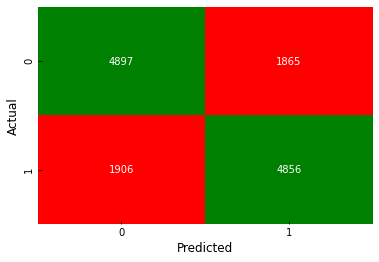

In [184]:
custom_confusion_matrix(y_test, y_pred);